動作チェックしていない。

# mpi4py

## mpi4pyのinstall

```sh
$ pip install mpi4py
```

## mpi実行できることの確認をしておく。
```sh
$ cd ~/external_code/sample
$ mpirun -np 2 ../add_mul3mpi.py Inputfile.txt
```

In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

# batch実行

externalcalc.addmul3@tutorをbatchで実行する。

AiiDA tutoral VMにはslurmがinstallされているのでslurmを用いる。

In [2]:
from aiida.engine import calcfunction,workfunction, WorkChain, ToContext, submit,run,while_
from aiida.orm import Str, Float, Int, Dict, Bool, load_node, load_code
import numpy as np
from aiida.plugins import DataFactory, CalculationFactory
import time

from aiida.common.datastructures import CalcInfo, CodeInfo
from aiida.common.folders import Folder
from aiida.engine import CalcJob, CalcJobProcessSpec

# computerとcodeのsetup

## ssh login するcomputerの設定
```sh
$ verdi computer setup
Info: enter "?" for help
Info: enter "!" to ignore the default and set no value
Computer label: tutor_submit
Hostname: localhost
Description []: 
Transport plugin: ssh
Scheduler plugin: slurm
Shebang line (first line of each script, starting with #!) [#!/bin/bash]: 
Work directory on the computer [/scratch/{username}/aiida/]: 
Mpirun command [mpirun -np {tot_num_mpiprocs}]: 
Default number of CPUs per machine: 4
/home/max/.virtualenvs/aiida/lib/python3.6/site-packages/aiida/schedulers/scheduler.py:90: AiidaDeprecationWarning: method is deprecated, use `aiida.plugins.entry_point.get_entry_point_names` instead
  warnings.warn(message, AiidaDeprecationWarning)  # pylint: disable=no-member
Success: Computer<6> tutor_submit created
Info: Note: before the computer can be used, it has to be configured with the command:
Info:   verdi computer configure ssh tutor_submit

```

In [3]:
! verdi computer show tutor_submit

--------------  ------------------------------------
Label           tutor_submit
PK              3
UUID            6a172016-1178-4e82-bd83-ee3993dfe5f9
Description
Hostname        localhost
Transport type  ssh
Scheduler type  slurm
Work directory  /home/{username}/aiida/
Shebang         #!/bin/bash
Mpirun command  mpirun -np {tot_num_mpiprocs}
Prepend text
Append text
--------------  ------------------------------------


## sshの設定
```sh
$ verdi computer configure ssh tutor_submit
Info: enter "?" for help
Info: enter "!" to ignore the default and set no value
User name [max]: 
port Nr [22]: 
Look for keys [True]: 
SSH key file []: 
Connection timeout in s [60]: 
Allow ssh agent [True]: 
SSH proxy command []: 
Compress file transfers [True]: 
GSS auth [False]: 
GSS kex [False]: 
GSS deleg_creds [False]: 
GSS host [localhost]: 
Load system host keys [True]: 
Key policy (RejectPolicy, WarningPolicy, AutoAddPolicy) [RejectPolicy]: 
Connection cooldown time (s) [30.0]: 5
Info: Configuring computer tutor_submit for user aiida@localhost.
Success: tutor_submit successfully configured for aiida@localhost
```
テスト用にwooldown timeを小さくする。

In [4]:
! verdi computer configure show tutor_submit

* username               max
* port                   22
* look_for_keys          True
* key_filename
* timeout                60
* allow_agent            True
* proxy_command
* compress               True
* gss_auth               False
* gss_kex                False
* gss_deleg_creds        False
* gss_host               localhost
* load_system_host_keys  True
* key_policy             RejectPolicy
* use_login_shell        True
* safe_interval          5.0


In [5]:
! verdi computer test tutor_submit

Info: Testing computer<tutor_submit> for user<aiida@localhost>...
* Opening connection... [OK]
* Checking for spurious output... [OK]
* Getting number of jobs from scheduler... [OK]: 0 jobs found in the queue
* Determining remote user name... [OK]: max
* Creating and deleting temporary file... [OK]
Success: all 5 tests succeeded


In [6]:
! verdi computer list

Info: List of configured computers
Info: Use 'verdi computer show COMPUTERLABEL' to display more detailed information
* tutor
* tutor_submit


tutor_submitが見えるようになる。

## tutor_submitを使ったcodeのsetup

```sh
$ verdi code setup
Info: enter "?" for help
Info: enter "!" to ignore the default and set no value
Label: externalcalc.addmul3_submit
Description []: 
Default calculation input plugin: externalcalc.addmul3
Installed on target computer? [True]: 
Computer: tutor_submit
Remote absolute path: /home/max/external_code/add_mul3.py
```


In [7]:
!verdi code show externalcalc.addmul3_submit@tutor_submit

--------------------  ------------------------------------
PK                    829
UUID                  9e3d31b1-0c0a-4bbb-9487-f657ebae6909
Label                 externalcalc.addmul3_submit
Description
Default plugin        externalcalc.addmul3
Type                  remote
Remote machine        tutor_submit
Remote absolute path  /home/max/external_code/add_mul3.py
Prepend text
Append text
--------------------  ------------------------------------


# daemon再起動
```sh
$ verdi daemon restart --reset
```
とjupyter kernelの再起動を行う。


# batch queue + run for debug
batch queueを run()で動かす。

tot_num_mpiprocs =  num_machines * num_mpiprocs_per_machine 

In [8]:
from externalcalc.pythoncalc.calculations.addmul3 import externalAddMulCalculation
from externalcalc.pythoncalc.parsers.addmul3 import externalAddMulParser
externaladdmul = externalAddMulCalculation

inputs = {
    "x":Int(1), "y":Int(2), "z":Int(4), "input_filename": Str("Inputfile.txt"),
    'code': load_code('externalcalc.addmul3_submit@tutor_submit'), 
    'metadata': {
        'options': {
            'resources': {'tot_num_mpiprocs': 2, 'num_machines': 1}
          #  'resources': {'num_mpiprocs_per_machine': 1, 'num_machines': 2}
        }
     }
}
result, node = run.get_node(externaladdmul, **inputs)
print(result)
pk = result["result"].pk
print(pk)

07/28/2021 07:40:34 AM <9139> aiida.orm.nodes.process.calculation.calcjob.CalcJobNode: [REPORT] [834|externalAddMulCalculation|prepare_for_submission]: values 1.2.4


Input_filename Inputfile.txt
calcinfo.retrieve_list ['aiida.out', 'Outputfile.txt']
parser: outputfilename Outputfile.txt
{'result': <Float: uuid: 5744c95b-546b-417e-b748-b004bb6720f9 (pk: 837) value: 12.0>, 'retrieved': <FolderData: uuid: 37e4a23a-3628-4c1d-9985-ff099a5f3a8b (pk: 836)>, 'remote_folder': <RemoteData: uuid: 117a695d-1c9c-4e3c-881f-bf3e286520c3 (pk: 835)>}
837


結果の表示

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 837.dot.pdf


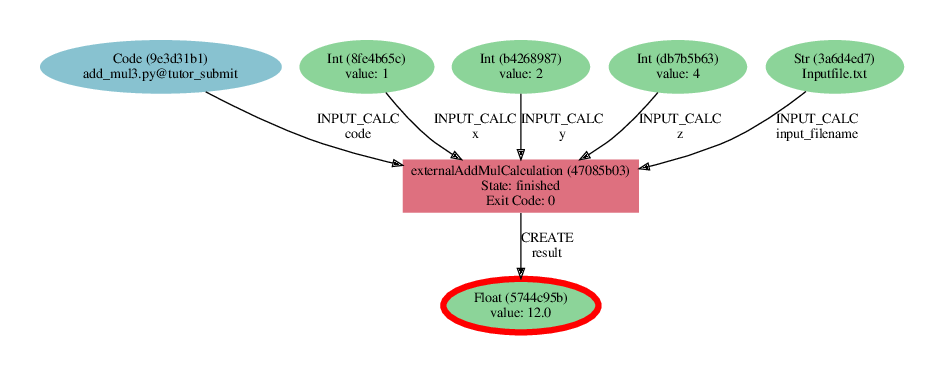

In [9]:
!verdi node graph generate $pk
from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# batch queue + submit
batch queueを submit()で動かす。

In [10]:
code = load_code("externalcalc.addmul3_submit@tutor_submit")
builder = code.get_builder()
builder.x = Int(1)
builder.y = Int(2)
builder.z = Int(4)
builder.input_filename = Str("Inputfile.txt")
builder.metadata = {
        'options': {
           'resources': {'tot_num_mpiprocs': 2, 'num_machines': 1}
           # 'resources': {'num_machines': 1, 'num_mpiprocs_per_machine': 2}
        } }

workchain_node = submit(builder)
print(workchain_node.pk)
pk = workchain_node.pk

842


途中経過を見るには
```sh
$ verdi process list -a
```
もしくは
```sh
$ verdi process list -p1
```

calculations pluginが何かしら書き出していれば以下でもmessageが出る。
```sh
$ verdi process watch <PK>
```
```sh 
$ verdi process report <PK>
```


In [11]:
print(workchain_node.exception)
while not workchain_node.is_finished:
    print(workchain_node.exception)
    time.sleep(5)
print(workchain_node.is_finished, workchain_node.is_finished_ok)
print(workchain_node.outputs.result)

None
None
None
None
None
None
True True
uuid: b5610a49-9103-4010-8c54-3aa7cbf19156 (pk: 845) value: 12.0


In [12]:
pk = workchain_node.pk
!verdi node graph generate $pk
from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

Info: Initiating graphviz engine: dot
Info: Recursing ancestors, max depth=None
Info: Recursing descendants, max depth=None
Success: Output file: 842.dot.pdf


also execute
```sh
$ verdi calcjob gotocomputer <workchain_node.pk>
```

```sh
$ ls
Inputfile.txt   _aiidasubmit.sh        _scheduler-stdout.txt
Outputfile.txt  _scheduler-stderr.txt  aiida.out
```

```sh
$ cat Outputfile.txt 
12.0
```

Ref. 
https://github.com/aiidateam/aiida-diff/blob/master/aiida_diff/calculations.py